In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import time

Set random seed for repeatability.

In [2]:
np.random.seed(seed=11011)

User-specified parameters:

* `m` is number of points in source cloud
* `n` is number of points in target cloud
* `noise_val` is the 1-sigma value for applying noise (per channel $x,y$)
* `ang` is the rotation angle (ccw is positive) to apply
* `xt` is the $x$ translation to apply
* `yt` is the $y$ translation to apply

In [3]:
m, n = 15, 25
noise_val = 0.
ang = np.pi / 4.
xt, yt = 10.0, 15.0
side_length = 20

In [4]:
# uniformly sample on square with dimensions side_length x side_length
# use homogeneous coordinates
target_pts = side_length * np.random.random((4, n)) - 0.5 * side_length
target_pts[2, :] = 0.
target_pts[3, :] = 1.

# transform
ca, sa = np.cos(ang), np.sin(ang)
tgt_to_src = np.array([[ca, sa, 0., xt],
                       [-sa, ca, 0., yt],
                       [0., 0., 1., 0.],
                       [0., 0, 0., 1.]])
target_pts_xform = np.dot(tgt_to_src, target_pts)
correspondences = np.random.choice(n, m, replace=False)
# subsample and reorder target points
source_pts = target_pts_xform[:, correspondences] + noise_val*np.random.randn(4, m)
source_pts[2, :] = 0.
source_pts[3, :] = 1.

A _correspondence_ is encoded by two points:  one from the source point cloud and the other from the target point cloud.  Encode the correspondence of source point $i$ to target point $j$ as $i' \equiv i n + j$. 

In [5]:
correspondenceVertices = [] # for comparison below
for i,c in enumerate(correspondences):
    correspondenceVertices.append(i*n + c)

In [6]:
print("Correspondence vertices list is {}".format(correspondenceVertices))

Correspondence vertices list is [23, 41, 72, 88, 105, 137, 165, 189, 219, 234, 267, 283, 301, 328, 374]


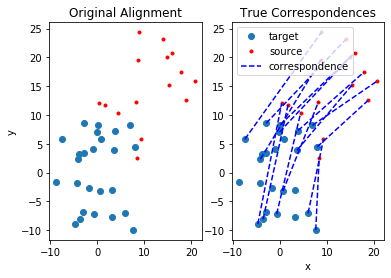

In [7]:
plt.figure()
ax1 = plt.subplot(121)
ax1.plot(target_pts[0, :], target_pts[1, :], 'o', source_pts[0, :], source_pts[1, :], 'r.')
ax1.set_ylabel("y")
ax1.set_title("Original Alignment")
ax2 = plt.subplot(122)
ax2.plot(target_pts[0, :], target_pts[1, :], 'o', label="target")
ax2.plot(source_pts[0, :], source_pts[1, :], 'r.', label="source")
legend_made = False
for i, c in enumerate(correspondences):
    if not legend_made:
        ax2.plot([target_pts[0, c], source_pts[0, i]], [target_pts[1, c], source_pts[1, i]], 'b--', label="correspondence")
        legend_made = True
    else:
        ax2.plot([target_pts[0, c], source_pts[0, i]], [target_pts[1, c], source_pts[1, i]], 'b--')
    ax2.legend()
    ax2.set_title("True Correspondences")
    ax2.set_xlabel("x")
plt.show()

Two correspondences are pairwise consistent _iff_:
* The source points from each correspondence are a minimum of `pairwiseThreshold` distance apart; call this distance `d1`
* The target points from each correspondence are a minimum of `pairwiseThreshold` distance apart; call this distance `d2`
* The absolute value of the difference between `d1` and `d2` is _at maximum_ `epsilon` distance apart.

In [8]:
def isPairwiseConsistent(ci, cj, epsilon=0.1, pwThresh=0.1):
    # ci - i*n + i', i \in source, i' \in target
    # cj - j*n + j', j \in source, j' \in target
    # ci.x is 3x1 numpy array
    # ci.y is 3x1 numpy array
    # cj.x is 3x1 numpy array
    # cj.y is 3x1 numpy array
    d1 = np.linalg.norm(ci["x"] - cj["x"])
    d2 = np.linalg.norm(ci["y"] - cj["y"])
    d3 = np.abs(d1 - d2)
    return  d1 >= pwThresh \
        and d2 >= pwThresh \
        and d3 <= epsilon

Simple helper utility to compare correspondence list to maximum clique computed from BnB-based strategies.

In [9]:
def cliquesAreEquivalent(cliqueOne, cliqueTwo):
    return cliqueOne.sort() == cliqueTwo.sort()

User-defined constants:
* `epsilon` above $\to$ `eps`
* `pairwiseThreshold` above $\to$ `pwThr`

In [10]:
eps = 1e-1
pwThr = 1e-1

Construct vertices and edges for maximum clique calculation.

In [11]:
E = []
V = [] 
for i in range(source_pts.shape[1]):
    for j in range(target_pts.shape[1]):
        for k in range(source_pts.shape[1]):
            for l in range(target_pts.shape[1]):
                if i != k and j != l:
                    ci = {"x": source_pts[:3, i], "y": target_pts[:3, j]}
                    cj = {"x": source_pts[:3, k], "y": target_pts[:3, l]}
                    consis = isPairwiseConsistent(ci, cj, epsilon = eps, pwThresh = pwThr)
                    if consis:
                        V1 = i*n + j
                        V2 = k*n + l
                        E.append((V1, V2))
                        if V1 not in V:
                            V.append(V1)
                        if V2 not in V:
                            V.append(V2)

## Maximum Clique Identification using `networkx`

In [12]:
import networkx as nx

In [13]:
G = nx.Graph()
G.add_edges_from(E)

In [14]:
cliques = list(nx.find_cliques_recursive(G))
#plt.figure()
#nx.draw(G, with_labels=True)
maxClique = []
maxCliqueSize = 0
tBegin = time.time()
for c in cliques:
    if len(c) > maxCliqueSize:
        maxClique = c
        maxCliqueSize = len(c)
timeElapsed = time.time() - tBegin

In [15]:
print("Max clique was found in {}sec".format(timeElapsed))
print("Max clique has size {}".format(maxCliqueSize))
print("Max clique is {}".format(maxClique))

Max clique was found in 0.000392913818359375sec
Max clique has size 15
Max clique is [105, 234, 165, 72, 328, 41, 137, 267, 301, 219, 374, 88, 283, 189, 23]


Check that `maxClique` is equivalent to the true correspondences.

In [16]:
print("Is the correspondence list equivalent to the max clique?  {}".format(cliquesAreEquivalent(correspondenceVertices, maxClique)))

Is the correspondence list equivalent to the max clique?  True


## Practical Maximum Clique Algorithms from the Paper

In [17]:
def adjacency(edges, vertex):
    adj = []
    for e in edges:
        if vertex in e:
            adj.append(e[0]) if vertex != e[0] else adj.append(e[1])
    return adj

In [18]:
# unit test for adjacency using graph from paper (Figure 2)
V = [1, 2, 3, 4, 5, 6]
E = [(1, 2), (1, 5), (1, 6), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5), (5, 6)]
for v in V:
    print("v: {}, adj(V): {}".format(v, adjacency(E, v)))

v: 1, adj(V): [2, 5, 6]
v: 2, adj(V): [1, 3, 4, 5]
v: 3, adj(V): [2, 4, 5]
v: 4, adj(V): [2, 3, 5]
v: 5, adj(V): [1, 2, 3, 4, 6]
v: 6, adj(V): [1, 5]


### Basic BnB (Algorithm 1)

In [19]:
def mcBasicBnB(S, edges):
    global R, Rbest
    """
    Algorithm 1 from paper "A Practical Maximal Clique for Matching with Pairwise Constraints" by
    Bustos et.al
    
    args:
    S - candidate vertices for expansion
    edges - edges of (undirected) graph
    """
    while S:
        if len(R) + len(S) <= len(Rbest):
            return
        v = S[0]
        R.append(v)
        Sprime = [vert for vert in S if vert in adjacency(edges, v)]
        if Sprime:
            mcBasicBnB(Sprime, edges)
        elif len(R) > len(Rbest):
            Rbest = deepcopy(R)
        R.remove(v)
        S.remove(v)

In [20]:
R, Rbest = [], []
V = [1, 2, 3, 4, 5, 6]
E = [(1, 2), (1, 5), (1, 6), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5), (5, 6)]
mcBasicBnB(V, E)
print("Rbest is: {}".format(Rbest))

Rbest is: [2, 3, 4, 5]


Which matches the article's result

Quick check:  _Does_ `mcqBasicBnB` _find the correspondences like the previous method tried (i.e. the one using_ `networkx` _)?_

In [21]:
E = []
V = [] 
for i in range(source_pts.shape[1]):
    for j in range(target_pts.shape[1]):
        for k in range(source_pts.shape[1]):
            for l in range(target_pts.shape[1]):
                if i != k and j != l:
                    ci = {"x": source_pts[:3, i], "y": target_pts[:3, j]}
                    cj = {"x": source_pts[:3, k], "y": target_pts[:3, l]}
                    consis = isPairwiseConsistent(ci, cj, epsilon = eps, pwThresh = pwThr)
                    if consis:
                        V1 = i*n + j
                        V2 = k*n + l
                        E.append((V1, V2))
                        if V1 not in V:
                            V.append(V1)
                        if V2 not in V:
                            V.append(V2)
R, Rbest = [], []
tBegin = time.time()
mcBasicBnB(V, E)
timeElapsed = time.time() - tBegin
print("Max clique was found in {}sec".format(timeElapsed))
maxCliqueBasicBnB = deepcopy(Rbest)
print("Is the correspondence list equivalent to the mcBasicBnB maximum clique?  {}".format(cliquesAreEquivalent(correspondenceVertices, maxCliqueBasicBnB)))

Max clique was found in 4.391311883926392sec
Is the correspondence list equivalent to the mcBasicBnB maximum clique?  True


Cool.  `maxCliqueBasicBnB` works but is pretty slow (though it is faster than the quadratic assignment approach).  Let's try Algorithm 2.

### MCQ (Algorithm 2)

In [22]:
def first_available(colors):
    """Return smallest integer not in the given list of colors."""
    count = [0] * (len(colors) + 1)       # Allocate long-enough array of zeros
    for color in colors:
        if color < len(count):
            count[color] += 1
    for color in range(len(colors) + 1):
        if count[color] == 0:
            return color

In [23]:
def greedy_color(vertices, edges):
    """Find the greedy coloring of graph defined by edges in the given vertices.
    """
    color = dict()
    for v in vertices:
        color[v] = first_available([color[w] for w in adjacency(edges, v) if w in color])
    for key in color:
        color[key] += 1  # make sure to start coloring from 1
    return color

In [24]:
def mcMCQ(S, edges, f):
    global R, Rbest
    """
    Algorithm 2 from paper "A Practical Maximal Clique for Matching with Pairwise Constraints" by
    Bustos et.al
    
    args:
    S - candidate vertices for expansion
    edges - edges of (undirected) graph
    f - coloring of vertices for expansion (len(f) == len(S), by necessity)
    """
    # reorder vertices in S by adjacency
    #Ssrt = sorted(S, key=lambda x: len(adjacency(edges, x)), reverse=True)  # this does not work
    Ssrt = sorted(S, key=lambda x: len(adjacency(edges, x)), reverse=False)  # this works, want to expand about vertex of largest degree first
    #Ssrt = S  # this also works
    while Ssrt:
        v = Ssrt[-1]
        if len(R) + f[v] <= len(Rbest):
            return
        R.append(v)
        Sprime = [vert for vert in Ssrt if vert in adjacency(edges, v)]
        if Sprime:
            fprime = greedy_color(Sprime, edges)
            mcMCQ(Sprime, edges, fprime)
        elif len(R) > len(Rbest):
            Rbest = deepcopy(R)
        R.remove(v)
        Ssrt.remove(v)

In [25]:
R, Rbest = [], []
V = [1, 2, 3, 4, 5, 6]
E = [(1, 2), (1, 5), (1, 6), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5), (5, 6)]
f = greedy_color(V, E)
#print(f)
mcMCQ(V, E, f)
print("Rbest is: {}".format(Rbest))

Rbest is: [5, 2, 4, 3]


In [26]:
E = []
V = [] 
for i in range(source_pts.shape[1]):
    for j in range(target_pts.shape[1]):
        for k in range(source_pts.shape[1]):
            for l in range(target_pts.shape[1]):
                if i != k and j != l:
                    ci = {"x": source_pts[:3, i], "y": target_pts[:3, j]}
                    cj = {"x": source_pts[:3, k], "y": target_pts[:3, l]}
                    consis = isPairwiseConsistent(ci, cj, epsilon = eps, pwThresh = pwThr)
                    if consis:
                        V1 = i*n + j
                        V2 = k*n + l
                        E.append((V1, V2))
                        if V1 not in V:
                            V.append(V1)
                        if V2 not in V:
                            V.append(V2)
R, Rbest = [], []
f = greedy_color(V, E)
tBegin = time.time()
mcMCQ(V, E, f)
timeElapsed = time.time() - tBegin
maxCliqueMCQ = deepcopy(Rbest)
print("Max clique was found in {}sec".format(timeElapsed))
print("Is the correspondence list equivalent to the mcMCQ maximum clique?  {}".format(cliquesAreEquivalent(correspondenceVertices, maxCliqueBasicBnB)))

Max clique was found in 0.07146430015563965sec
Is the correspondence list equivalent to the mcMCQ maximum clique?  True


### Practical Maximum Clique (Algorithm 3)
_This algorithm does not work yet_

In [33]:
def computeC(S, F, edges):
    U = S + F  # compute union S \union F
    maxDegree = 0
    C = deepcopy(S)
    vMaxDeg = None
    for v in U:
        degree = len([x for x in S if x in adjacency(edges, v)])
        if degree > maxDegree:
            vMaxDeg = v
            maxDegree = degree
    if not vMaxDeg:
        return []
    for x in adjacency(edges, vMaxDeg):
        if x in C:
            C.remove(x)
    return C

In [36]:
def mcPMC(S, edges, F, f):
    global R, Rbest
    """
    Algorithm 3 from paper "A Practical Maximal Clique for Matching with Pairwise Constraints" by
    Bustos et.al
    
    args:
    S - candidate vertices for expansion
    edges - edges of (undirected) graph
    F - list of removed vertices
    f - coloring of vertices for expansion (len(f) == len(S), by necessity)
    """
    # reorder vertices in S by adjacency
    #Ssrt = sorted(S, key=lambda x: len(adjacency(edges, x)), reverse=True)  # this does not work
    #Ssrt = sorted(S, key=lambda x: (len(adjacency(edges, x)), -x), reverse=False)  # second sort doesn't work either
    Ssrt = sorted(S, key=lambda x: len(adjacency(edges, x)), reverse=False)
    print(Ssrt)
    C = computeC(Ssrt, F, edges)
    print("C: {}".format(C))
    i = len(Ssrt) - 1
    #print(i)
    while i >= 0:
        #print(i)
        max_color = max([f[vi] for vi in Ssrt])
        #print(max_color)
        if len(R) + max_color <= len(Rbest):
            #print("f: {}".format([f[v] for v in Ssrt]))
            #print("S: {}".format(Ssrt))
            #print("len(R): {}, mc: {}, len(Rbest): {}".format(len(R), max_color, len(Rbest)))
            return
        v = Ssrt[i]
        if v in C:
            print("v: {}".format(v))
            R.append(v)
            Sprime = [vert for vert in Ssrt if vert in adjacency(edges, v)]
            print("S': {}".format(Sprime))
            if len(Sprime) != 0:
                #Fprime = [vert for vert in F if vert in adjacency(edges, v)]
                Fprime = [vert for vert in F if vert in adjacency(edges, v)]
                fprime = greedy_color(Sprime, edges)
                mcPMC(Sprime, edges, Fprime, fprime)
            elif len(R) > len(Rbest):
                Rbest = deepcopy(R)
            #print(R)
            R.remove(v)
            Ssrt.remove(v)
            F.append(v)
            #print(F)
            #f = greedy_color(Ssrt, edges)
            #print(f)
        i -= 1

In [37]:
R, Rbest = [], []
V = [1, 2, 3, 4, 5, 6]
#V = [4, 2, 3, 1, 5, 6]
E = [(1, 2), (1, 5), (1, 6), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5), (5, 6)]
f = greedy_color(V, E)
F = []
mcPMC(V, E, F, f)
print("Rbest is: {}".format(Rbest))

[6, 1, 3, 4, 2, 5]
C: [5]
v: 5
S': [6, 1, 3, 4, 2]
[6, 1, 3, 4, 2]
C: [6, 2]
v: 2
S': [1, 3, 4]
[1, 3, 4]
C: [1, 3]
v: 3
S': [4]
[4]
C: []
v: 1
S': []
Rbest is: [5, 2, 1]
